In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm
import torch

import warnings
warnings.filterwarnings('ignore')

## Зачем
- Посмотрим, как проводится операция свертки, pooling и flatten;    
- Попробуем собрать сверточную нейронную сеть на PyTorch

## Цветовые каналы

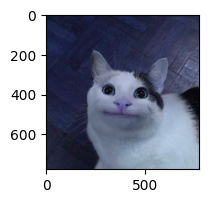

In [2]:
image = cv2.imread('./image.png')
plt.figure(figsize=(2,2))
plt.imshow(image);

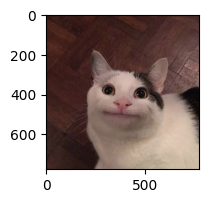

In [3]:
image_ex = image[...,::-1]
plt.figure(figsize=(2,2))
plt.imshow(image_ex)

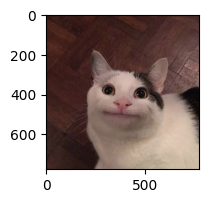

In [4]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(2,2))
plt.imshow(image_rgb);

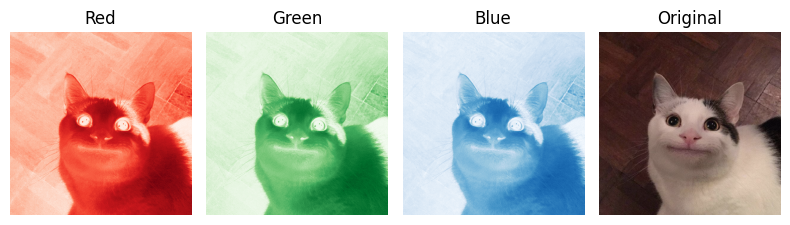

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

img_mat = np.array(image_rgb)

fig, axs = plt.subplots(1, 4, figsize=(8, 8))

axs[0].imshow(img_mat[:, :, 0], cmap=cm.Reds)
axs[0].set_title('Red')
axs[0].axis('off')

axs[1].imshow(img_mat[:, :, 1], cmap=cm.Greens)
axs[1].set_title('Green')
axs[1].axis('off')

axs[2].imshow(img_mat[:, :, 2], cmap=cm.Blues)
axs[2].set_title('Blue')
axs[2].axis('off')

axs[3].imshow(img_mat[:, :, :])
axs[3].set_title('Original')
axs[3].axis('off')

plt.tight_layout()
plt.show()


## Операция свертки 

- Количество входных каналов in_channels
- Количество выходных каналов out_channels
- Размер ядра kernel_size
- Шаг stride
- Паддинг padding
- Режим паддинга padding_mode ('zeros', 'reflect', ...)

In [6]:
bw_image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)

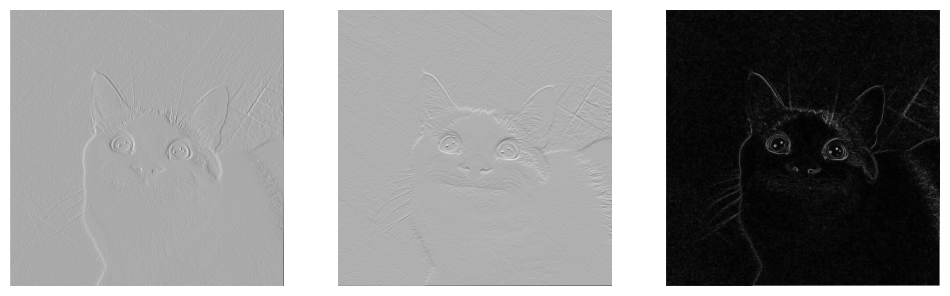

In [7]:
from scipy.signal import convolve2d

G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
res_y = convolve2d(bw_image, G_y, "same")
res_sobel = (res_x**2 + res_y**2)**0.5



fig, axs = plt.subplots(1, 3, figsize=(12, 12))

axs[0].imshow(res_x, cmap=plt.cm.Greys_r)
axs[0].axis('off')

axs[1].imshow(res_y, cmap=plt.cm.Greys_r)
axs[1].axis('off')

axs[2].imshow(res_sobel)
axs[2].axis('off')

plt.imshow(res_sobel, cmap=plt.cm.Greys_r);

## Операция свертки с нуля (conv2d)

In [8]:
from PIL import Image, ImageOps

In [9]:
img = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)

In [10]:
def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    

def plot_two_images(img1: np.array, img2: np.array):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img1, cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(img2, cmap='gray')
    ax[1].axis('off')

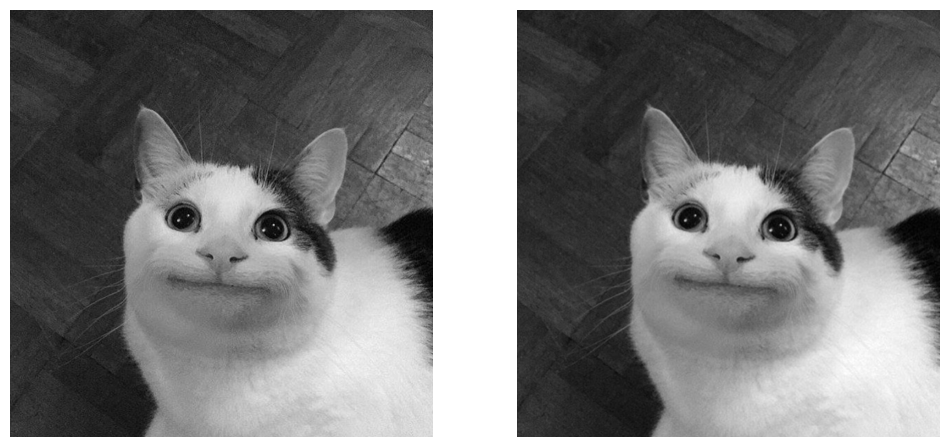

In [11]:
import numpy as np

def calculate_target_size(img_size: int, kernel_size: int, stride=1) -> int:
    """Размер выходной матрицы после применения свёртки"""
    
    return (img_size - kernel_size) // stride + 1


def convolve(img: np.array, kernel: np.array) -> np.array:
    # Размеры изображения и ядра
    img_h, img_w = img.shape
    kernel_h, kernel_w = kernel.shape
    
    # Вычисляем целевые размеры для свёртки
    tgt_h = calculate_target_size(img_h, kernel_h)
    tgt_w = calculate_target_size(img_w, kernel_w)
    
    # Массив для хранения результата свёртки
    convolved_img = np.zeros((tgt_h, tgt_w))
    
    # Проходим по строкам изображения
    for i in range(tgt_h):
        # Проходим по столбцам изображения
        for j in range(tgt_w):
            # Извлекаем подматрицу изображения, соответствующую размеру ядра
            mat = img[i:i+kernel_h, j:j+kernel_w]
            
            # Применяем свёртку: поэлементное умножение и суммирование
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
            
    return convolved_img


sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

blur = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125,  0.25,  0.125],
    [0.0625, 0.125, 0.0625]
])


img_with_kernel = convolve(img=img, kernel=blur)
plot_two_images(
    img1=img, 
    img2=img_with_kernel
)

# Max pooling

In [21]:
import numpy as np
from numpy.lib.stride_tricks import as_strided


def pool2d(A, kernel_size, stride, padding=0, pool_mode='max'):

    A = np.pad(A, padding, mode='constant')

    # Window view of A
    output_shape = ((A.shape[0] - kernel_size) // stride + 1,
                    (A.shape[1] - kernel_size) // stride + 1)
    
    shape_w = (output_shape[0], output_shape[1], kernel_size, kernel_size)
    strides_w = (stride*A.strides[0], stride*A.strides[1], A.strides[0], A.strides[1])
    
    A_w = as_strided(A, shape_w, strides_w)

    # Return the result of pooling
    return A_w.max(axis=(2, 3))
    

A = np.array([[1, 1, 2, 4],
              [5, 6, 7, 8],
              [3, 2, 1, 0],
              [1, 2, 3, 4]])

pool2d(A, kernel_size=2, stride=2, padding=0, pool_mode='max')

array([[6, 8],
       [3, 4]])

## Flatten

In [4]:
from IPython.display import Video

Video("flatten.mp4", width=920, height=920)

#### В PyTorch

In [2]:
t = torch.tensor([[[1, 2],
                   [3, 4]],
                  [[5, 6],
                   [7, 8]]])

In [3]:
torch.flatten(t)

tensor([1, 2, 3, 4, 5, 6, 7, 8])

In [4]:
torch.flatten(t, start_dim=1)

tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])

#### В Numpy

In [ ]:
t2 = np.array([[[1,2], [3,4]], [[5,6], [7,8]]])
t2.flatten()

## Сверточная нейронная сеть для бинарной классификации

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

### Подгрузка данных

In [3]:
data_dir = './PetImages/'

transform = transforms.Compose([
    transforms.Resize((128, 128)),   
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])  
])

full_data = ImageFolder(data_dir, transform=transform)

train_size = int(0.8 * len(full_data))
val_size = int(0.1 * len(full_data))
test_size = len(full_data) - train_size - val_size

train_data, val_data, test_data = random_split(full_data, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [4]:
# Для логирования в Tensorboard
writer = SummaryWriter('runs/cats_vs_dogs_experiment_1')

2024-09-19 13:35:38.069741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-19 13:35:38.709469: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-09-19 13:35:38.709545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-09-19 13:35:38.709553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [6]:
model = CNN()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
def save_checkpoint(state, filename='checkpoint.pth'):
    """Сохранение состояния модели"""
    torch.save(state, filename)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
        
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)
        

        if val_acc > best_val_acc:
            print(f'Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving model...')
            best_val_acc = val_acc
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'accuracy': val_acc
            }
            save_checkpoint(checkpoint, 'cnn_best_checkpoint.pth')
            
    
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(loader)
    accuracy = correct / total
    return loss, accuracy


In [8]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

  0%|                                                    | 0/20 [00:00<?, ?it/s]/home/user/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch [1/20], Loss: 0.6006, Accuracy: 0.6710, Val Loss: 0.5304, Val Accuracy: 0.7219
Validation accuracy improved from 0.0000 to 0.7219. Saving model...


  5%|██▏                                         | 1/20 [00:58<18:32, 58.55s/it]

Epoch [2/20], Loss: 0.4752, Accuracy: 0.7736, Val Loss: 0.4612, Val Accuracy: 0.7751
Validation accuracy improved from 0.7219 to 0.7751. Saving model...


 10%|████▍                                       | 2/20 [01:56<17:24, 58.02s/it]

Epoch [3/20], Loss: 0.4018, Accuracy: 0.8197, Val Loss: 0.4127, Val Accuracy: 0.8131
Validation accuracy improved from 0.7751 to 0.8131. Saving model...


 15%|██████▌                                     | 3/20 [02:54<16:30, 58.28s/it]

Epoch [4/20], Loss: 0.3458, Accuracy: 0.8493, Val Loss: 0.3683, Val Accuracy: 0.8387
Validation accuracy improved from 0.8131 to 0.8387. Saving model...


 20%|████████▊                                   | 4/20 [03:53<15:34, 58.41s/it]

Epoch [5/20], Loss: 0.2885, Accuracy: 0.8788, Val Loss: 0.3841, Val Accuracy: 0.8423
Validation accuracy improved from 0.8387 to 0.8423. Saving model...


 30%|█████████████▏                              | 6/20 [05:50<13:38, 58.44s/it]

Epoch [6/20], Loss: 0.2250, Accuracy: 0.9066, Val Loss: 0.4607, Val Accuracy: 0.8211


 35%|███████████████▍                            | 7/20 [06:43<12:18, 56.77s/it]

Epoch [7/20], Loss: 0.1665, Accuracy: 0.9328, Val Loss: 0.4974, Val Accuracy: 0.8275
Epoch [8/20], Loss: 0.1177, Accuracy: 0.9545, Val Loss: 0.5038, Val Accuracy: 0.8427
Validation accuracy improved from 0.8423 to 0.8427. Saving model...


 40%|█████████████████▌                          | 8/20 [07:39<11:17, 56.42s/it]

Epoch [9/20], Loss: 0.0849, Accuracy: 0.9692, Val Loss: 0.5276, Val Accuracy: 0.8459
Validation accuracy improved from 0.8427 to 0.8459. Saving model...


 50%|█████████████████████▌                     | 10/20 [09:31<09:22, 56.27s/it]

Epoch [10/20], Loss: 0.0653, Accuracy: 0.9762, Val Loss: 0.6605, Val Accuracy: 0.8431
Epoch [11/20], Loss: 0.0539, Accuracy: 0.9801, Val Loss: 0.8773, Val Accuracy: 0.8471
Validation accuracy improved from 0.8459 to 0.8471. Saving model...


 60%|█████████████████████████▊                 | 12/20 [11:20<07:22, 55.31s/it]

Epoch [12/20], Loss: 0.0531, Accuracy: 0.9820, Val Loss: 0.8881, Val Accuracy: 0.8459


 65%|███████████████████████████▉               | 13/20 [12:16<06:28, 55.53s/it]

Epoch [13/20], Loss: 0.0486, Accuracy: 0.9857, Val Loss: 0.9421, Val Accuracy: 0.8367
Epoch [14/20], Loss: 0.0435, Accuracy: 0.9848, Val Loss: 0.9370, Val Accuracy: 0.8479
Validation accuracy improved from 0.8471 to 0.8479. Saving model...


 75%|████████████████████████████████▎          | 15/20 [14:07<04:37, 55.42s/it]

Epoch [15/20], Loss: 0.0404, Accuracy: 0.9874, Val Loss: 1.0400, Val Accuracy: 0.8443


 80%|██████████████████████████████████▍        | 16/20 [15:05<03:44, 56.19s/it]

Epoch [16/20], Loss: 0.0444, Accuracy: 0.9853, Val Loss: 0.9129, Val Accuracy: 0.8443


 85%|████████████████████████████████████▌      | 17/20 [16:01<02:48, 56.06s/it]

Epoch [17/20], Loss: 0.0347, Accuracy: 0.9874, Val Loss: 0.9227, Val Accuracy: 0.8287


 90%|██████████████████████████████████████▋    | 18/20 [16:53<01:49, 54.95s/it]

Epoch [18/20], Loss: 0.0367, Accuracy: 0.9872, Val Loss: 1.1646, Val Accuracy: 0.8371


 95%|████████████████████████████████████████▊  | 19/20 [17:48<00:54, 54.77s/it]

Epoch [19/20], Loss: 0.0270, Accuracy: 0.9916, Val Loss: 1.4424, Val Accuracy: 0.8407


100%|███████████████████████████████████████████| 20/20 [18:42<00:00, 56.13s/it]

Epoch [20/20], Loss: 0.0396, Accuracy: 0.9882, Val Loss: 1.1380, Val Accuracy: 0.8271


![title](img/tensorboard_res.png)

## Инференс

In [12]:
def load_checkpoint(filename='checkpoint.pth'):
    
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict']) 
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  
    epoch = checkpoint['epoch'] 
    loss = checkpoint['loss'] 
    accuracy = checkpoint['accuracy']  
    print(f"Checkpoint loaded. Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}")
    return epoch, loss, accuracy

# Загрузка чекпоинта
model = CNN().to(device)  # Инициализация модели
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Инициализация оптимизатора

# Восстановление модели и оптимизатора из чекпоинта
epoch, loss, accuracy = load_checkpoint('cnn_best_checkpoint.pth')

# Перевод модели в режим инференса
model.eval()


Checkpoint loaded. Epoch: 14, Loss: 0.9369641693332528, Accuracy: 0.8479391756702681


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=32768, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

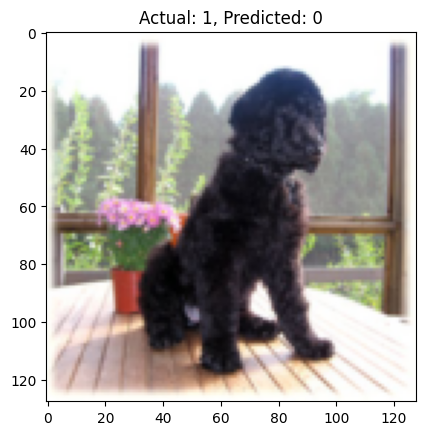

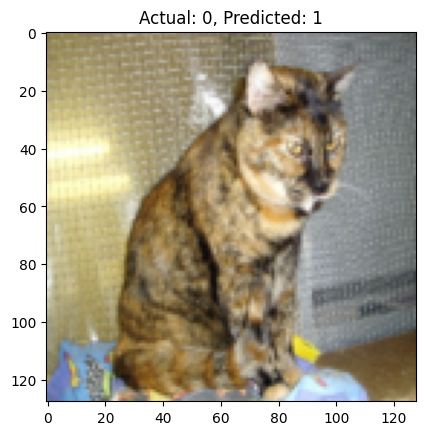

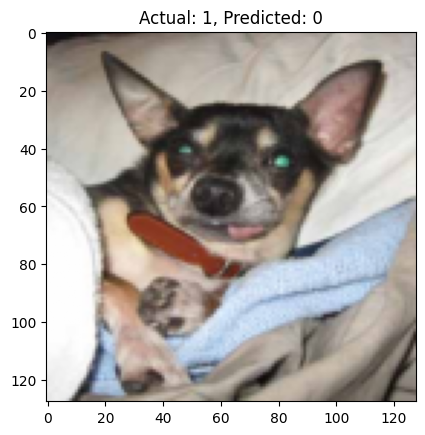

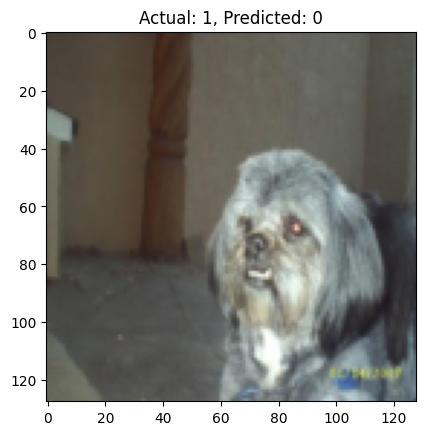

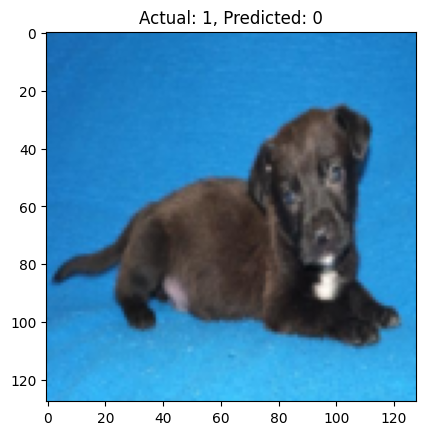

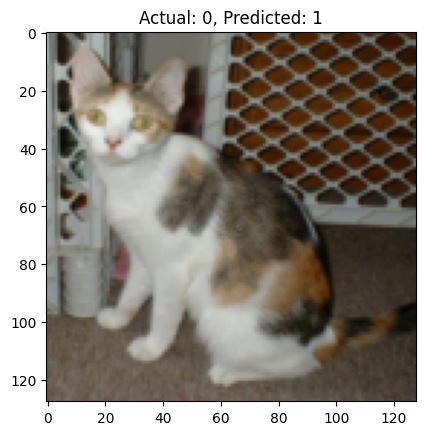

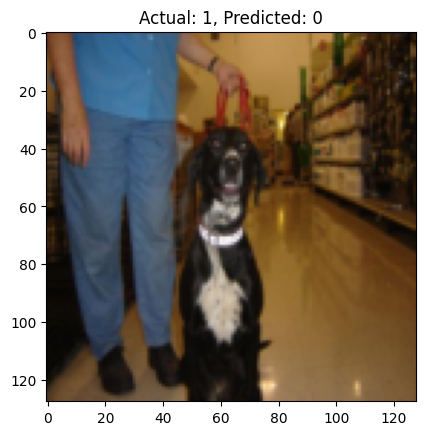

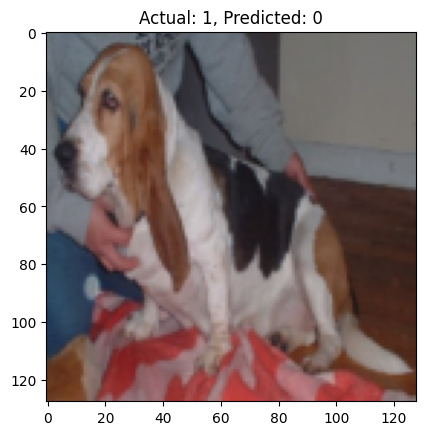

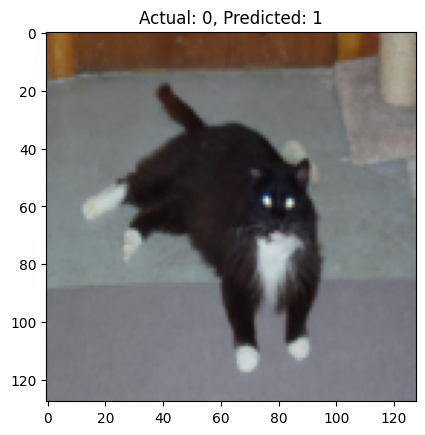

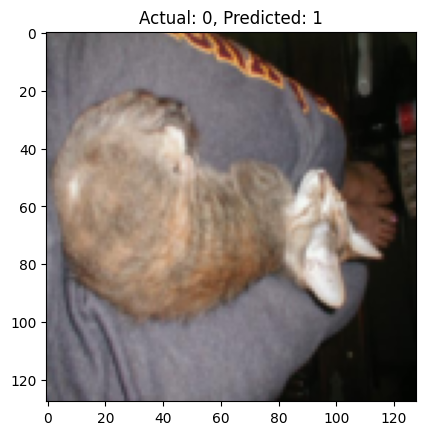

In [16]:
def imshow(img, title):
    """Функция для отображения изображения"""
    img = img / 2 + 0.5  # Деинвертируем нормализацию
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(title)
    plt.show()

def inference_and_visualize_errors(model, test_loader):
    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            predicted = (outputs > 0.5).float().view(-1)

            incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]

            for idx in incorrect_indices:
                incorrect_images.append(inputs[idx].cpu())
                incorrect_labels.append(labels[idx].cpu().item())
                incorrect_preds.append(predicted[idx].cpu().item())

    for i in range(min(10, len(incorrect_images))):
        imshow(incorrect_images[i], f'Actual: {int(incorrect_labels[i])}, Predicted: {int(incorrect_preds[i])}')

        writer.add_image(f'Error_{i}', incorrect_images[i])
        writer.add_text(f'Error_{i}', f'Actual: {int(incorrect_labels[i])}, Predicted: {int(incorrect_preds[i])}')

inference_and_visualize_errors(model, test_loader)


# Домашнее задание

Обучить бинарный классификатор на основе сверточных нейронных сетей для датасета.
- Вы вольны выбирать любое количество слоёв, подбирать гиперпараметры, выбирать оптимизатор, функцию ошибки итд.    
- Можете разбивать на train-val-test исходя из того, как думаете, что будет лучше.

4 балла:
- Модель должна работоспособна, воспроизводима, код должен быть читаемым;
- Метрика качества accuracy должна быть не ниже 0.9;
- Процесс схождения должен быть залогирован (хотя бы просто графиками в matplotlib, но желательно втч. и в Tensorboard/ClearML/...).

5 баллов:
- Всё то же самое, что на 4 балла, но выполнены подзадания 1, 2 и 3, а метрика качества accuracy должна быть не ниже 0.95.



Подзадания:
1) Выведите кол-во обучаемых параметров сети;    
2) Напишите несколько предложений выводов - что помогло в решении и повысило качество, что нет.    
3) Посчитайте F1-score на тестовой подвыборке.

По желанию к выполнению, в разбалловке не учитывается:     
3) Выведите confusion matrix для тестовой подвыборки;    